# Assignment 6

[3 points] Delelop language model, which generates texts from wikipedia.   
Use WikiText-2 dataset, also available in `torchtext.datasets`.  
Use `sentencepiece` or `tokenizers` library for text tokenization. Pay attention to vocab size, probably subword tokens are better.    
Your model should be autogressive RNN.  
[1 point] Plot train and validation loss depending on the number of iterations of gradient decent.  
[1 point] Try to use together (`sentencepiece` or `tokenizers`), `torchtext.datasets`, and `torchtext.data.BPTTIterator`  

<img src="images/lm.jpg" style="height:300px">

Text generation should be terminated when either max length is reached or terminal symbol is generated.  
Explore several inference techniques:
1. [1 point] Argmax
1. [1 point] Beamsearch
1. [1 point] Sampling from probabilty distribution with temperature
1. [1 point] Nucleus sampling
1. [1 point] Top-k sampling


For every method you should provide implemented code and generated examples. Each example must contain at least 10 words (not subword tokens).

Readings:
https://arxiv.org/abs/1904.09751

## Importing packages:

In [1]:
!pip install tokenizers

     |████████████████████████████████| 3.7MB 3.3MB/s 


In [0]:
from torchtext.datasets import WikiText2
from torchtext import data
from torchtext.vocab import Vocab

import urllib.request, os, zipfile, tokenizers, dill, json

from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers, ByteLevelBPETokenizer
from tqdm import tqdm_notebook
from collections import Counter

import torch as tt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir('/content/drive/My Drive/hw6')

## Declaring functions and classes:

In [0]:
download_file = lambda url, fname: urllib.request.urlretrieve(url, fname)

def download_n_unzip(url, dirname):
    zipname = dirname + '.zip'
    download_file(url, zipname)
    os.makedirs(dirname, exist_ok=True)
    
    with zipfile.ZipFile(zipname, 'r') as zfile:
        zfile.extractall(dirname)

def train_tokenizer(data_files, add_prefix_space=True, vocab_size=20000, min_frequency=2):
    ## Taken from example at https://pypi.org/project/tokenizers/
    
    # Initialize a tokenizer
    tokenizer = Tokenizer(models.BPE.empty())

    # Customize pre-tokenization and decoding
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel.new(add_prefix_space=add_prefix_space)
    tokenizer.decoder = decoders.ByteLevel.new()

    # And then train
    trainer = trainers.BpeTrainer.new(vocab_size=vocab_size, min_frequency=min_frequency)
    tokenizer.train(trainer, data_files)

    return tokenizer

In [0]:
def train_tokenizer(data_files, vocab_size=200000, min_frequency=2):
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train(data_files, vocab_size=vocab_size, min_frequency=min_frequency)
    return tokenizer

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True)
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, x):
        
        batch_size = x.size(1)
        total_length = x.size(0)
        
        x = self.embedding(x)
            
        x, _ = self.rnn(x)
        
        #x, _ = nn.utils.rnn.pad_packed_sequence(x, total_length=total_length, batch_first=True)
        
        x = x.contiguous().view(batch_size * total_length, -1)
        x = self.fc(x)
        x = x.contiguous().view(total_length, batch_size, -1)
        return x.transpose(1,2)

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch, device):

    model.train()

    running_loss = 0

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        
        x = batch.text.to(device)
        pred = model(x)
        
        y = batch.target.to(device)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        curr_loss = loss.data.cpu().detach().item()
        
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss='%.5f' % running_loss)

    return running_loss

def _test_epoch(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0

    n_batches = len(iterator)
    with tt.no_grad():
        for batch in iterator:
            
            x, y = batch.text.to(device), batch.target.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            epoch_loss += loss.data.cpu().detach().item()

    return epoch_loss / n_batches


def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, device, n_epochs=100,
          scheduler=None, early_stopping=0):

    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    for epoch in range(n_epochs):
        train_loss = _train_epoch(model, train_iterator, optimizer, criterion, epoch, device)
        valid_loss = _test_epoch(model, valid_iterator, criterion, device)

        valid_loss = valid_loss
        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history

In [0]:
def join_tokens(batch):
  for sent_id, sent in enumerate(batch):
    batch[sent_id] = ''.join([token.replace('Ġ', ' ') if token.startswith('Ġ') else token for token in sent])
  return batch

In [0]:
def decode_ids(batch, vocab):
  batch = batch.transpose(1,0)
  batch = [[vocab.itos[index] for index in sent] for sent in batch]
  return join_tokens(batch)

In [0]:
def decode_probas_argmax(outp, vocab):
  outp = outp.data.numpy()
  max_probas = np.argmax(outp, axis=1)
  return decode_ids(max_probas, vocab)

In [0]:
def continue_sentences(sents, field, device, lm):
  examples = field.process([field.preprocess(sent) for sent in sents])
  y_hat = lm(examples.to(device)).cpu() 
  return decode_probas_argmax(y_hat, field.vocab)

In [0]:
def dump_vocab(vocab, dir_name):
  os.makedirs(dir_name, exist_ok=True)
  with open(os.path.join(dir_name, 'freqs.json'), 'w', encoding='utf-8') as foutp:
    json.dump(vocab.freqs, foutp, ensure_ascii=False, indent=2)
  with open(os.path.join(dir_name, 'itos.json'), 'w', encoding='utf-8') as foutp:
    json.dump(vocab.itos, foutp, ensure_ascii=False, indent=2)
  with open(os.path.join(dir_name, 'stoi.json'), 'w', encoding='utf-8') as foutp:
    json.dump(vocab.stoi, foutp, ensure_ascii=False, indent=2)

In [0]:
def dump_model_weights(model, fname):
  tt.save(model.state_dict(), 'weights.pt')

In [0]:
def load_model(param_dict, state_dict_path):
  lm = MyModel(**param_dict)
  state_dict = tt.load(state_dict_path)
  lm.load_state_dict(state_dict)
  return lm

In [0]:
def load_vocab(dir_name):
  freqs_path = os.path.join(dir_name, 'freqs.json')
  itos_path = os.path.join(dir_name, 'itos.json')
  stoi_path = os.path.join(dir_name, 'stoi.json')

  with open(freqs_path, 'r', encoding='utf-8') as finp:
    freqs = Counter(json.load(finp))
  with open(itos_path, 'r', encoding='utf-8') as finp:
    itos = json.load(finp)
  with open(stoi_path, 'r', encoding='utf-8') as finp:
    stoi = json.load(finp)
  
  vocab = Vocab(freqs)
  vocab.itos = itos
  vocab.stoi = stoi

  return vocab

## Training model:

In [0]:
download_n_unzip('https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip', 'wikitext2')

In [0]:
vocab_size=100000

In [0]:
tokenizer = train_tokenizer(['wikitext2/wikitext-2/wiki.train.tokens'],
                           vocab_size=vocab_size)

In [0]:
tokenizer.save('', 'tokenizer')

['tokenizer-vocab.json', 'tokenizer-merges.txt']

In [0]:
TEXT = data.Field(tokenize=lambda x: tokenizer.encode(x).tokens, include_lengths=False)

In [0]:
train, valid, test = WikiText2.splits(TEXT)

In [0]:
TEXT.build_vocab(train)

In [0]:
tt.save(TEXT, 'TEXT', pickle_module=dill)

In [0]:
device = tt.device('cuda')
tt.cuda.empty_cache()

In [0]:
train_iter, valid_iter, test_iter = data.BPTTIterator.splits((train,valid,test),
    batch_size=64,
    bptt_len=30,
    device=tt.device('cpu'),
    shuffle=False,
    repeat=False)

In [0]:
lm = MyModel(vocab_size=vocab_size, embed_size=100, hidden_size=128).to(device)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(lm.parameters(), lr=1e-3, betas=(0.7, 0.99))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

In [0]:
history = nn_train(lm, train_iter, valid_iter, criterion, optimizer, scheduler=scheduler, 
        n_epochs=10, early_stopping=2)


validation loss 3.05863



validation loss 1.88153



validation loss 1.21916



validation loss 0.85793



validation loss 0.67778



validation loss 0.57419



validation loss 0.50464



validation loss 0.46692



validation loss 0.44659



validation loss 0.42832


In [0]:
history1 = history.set_index('epoch')

In [0]:
example = next(iter(train_iter))
x = decode_ids(example.text, TEXT.vocab)
y = decode_ids(example.target, TEXT.vocab)
y_hat = decode_probas_argmax(lm(example.text.to(device)).cpu(), TEXT.vocab)

In [0]:
for sent, target, predicted in list(zip(x, y, y_hat))[:5]:
  print(sent)
  print(target)
  print(predicted)
  print('\n')

 <eos> = Valkyria Chronicles III = <eos> <eos> SenjÅį no Valkyria 3 : <unk> Chronicles ( Japanese : æĪ¦åł´ãģ®ãĥ´ãĤ¡ãĥ«ãĤŃãĥ¥ãĥªãĤ¢3 , lit . Valkyria of
<eos> = Valkyria Chronicles III = <eos> <eos> SenjÅį no Valkyria 3 : <unk> Chronicles ( Japanese : æĪ¦åł´ãģ®ãĥ´ãĤ¡ãĥ«ãĤŃãĥ¥ãĥªãĤ¢3 , lit . Valkyria of the
<eos> = Valkyria Chronicles III = <eos> <eos> SenjÅį no Valkyria 3 : <unk> Chronicles ( Japanese : æĪ¦åł´ãģ®ãĥ´ãĤ¡ãĥ«ãĤŃãĥ¥ãĥªãĤ¢3 , lit . Valkyria of the


 they can eat , drink , fight , <unk> , <unk> , and die . Some have unique character traits . Set is aggressive and impulsive
 can eat , drink , fight , <unk> , <unk> , and die . Some have unique character traits . Set is aggressive and impulsive ,
 can eat , drink , fight , <unk> , <unk> , and die . Some have unique character traits . Set is aggressive and impulsive ,


 clerk , a purely decorative figure in the regime , began to acquire surprising authority " . It is Balaguer who guides much of the action in the last sections
 ,

In [0]:
len('Ġ')

1

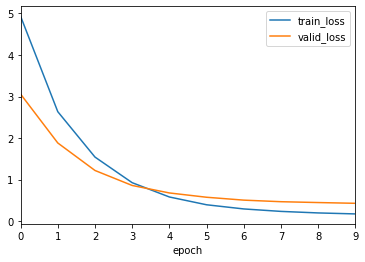

In [0]:
history1.plot()

In [0]:
TEXT.preprocess("I've got a bike, gonna ride it")

['I', "'", 've', 'Ġgot', 'Ġa', 'Ġbike', ',', 'Ġgonna', 'Ġride', 'Ġit']

In [0]:
decode_probas_argmax(lm(TEXT.process([TEXT.preprocess("I've got a bike, gonna ride it"),
TEXT.preprocess("Me gusta"),
TEXT.preprocess("")]).to(device)).cpu(), TEXT.vocab)

[' airport plus got a bike triangle hierarchical ride it is',
 'e Landing interviewing fisheries<pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']

In [0]:
examples = TEXT.process([TEXT.preprocess("I've got a bike, gonna ride it"),
TEXT.preprocess("Me gusta"),
TEXT.preprocess("")])

In [0]:
decode_ids(examples, TEXT.vocab)

["I've got a bike, gonna ride it",
 'Me gusta<pad><pad><pad><pad><pad><pad>',
 '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']

In [0]:
sent = "The Roman temple of Bziza is a well-preserved first century AD building dedicated to Azizos, a personification of the morning star in the Canaanite mythology. This Roman temple lends the modern Lebanese town of Bziza its current name as Bziza is a corruption of Beth Azizo meaning the house or temple of Azizos. Azizos is identified as Ares by Julian the Apostate."

In [0]:
sent = " "

In [0]:
for i in range(5):
  sent = continue_sentences([sent], TEXT, device)[0]
  print(sent)

tensor([[13]])
<eos>
tensor([[   0],
        [3702],
        [   0],
        [   7]])
e schemes Pattern and
tensor([[ 3702],
        [13371],
        [29198],
        [    9]])
 schemes welcomed and the
tensor([[13371],
        [13442],
        [    9],
        [    2]])
 welcomed and the <
tensor([[13442],
        [    9],
        [    2],
        [    6]])
 and the <unk


In [0]:
dump_model_weights(lm, 'weights.pt')

In [0]:
weights = tt.load("weights.pt")

In [0]:
dump_vocab(TEXT.vocab, 'Vocab')

## Using model to generate text

Load model, tokenizer and vocab:

In [0]:
model_params = {'vocab_size': 100000,
                'embed_size': 100,
                'hidden_size': 128}
lm = load_model(model_params, "weights.pt")
tokenizer = ByteLevelBPETokenizer(vocab_file='tokenizer-vocab.json',
                                  merges_file='tokenizer-merges.txt')
vocab = load_vocab('Vocab')
TEXT = data.Field(tokenize=lambda x: tokenizer.encode(x).tokens, include_lengths=False)
TEXT.vocab = vocab

In [0]:
device = tt.device('cpu')

In [0]:
pad_seq = tt.LongTensor([[1] for i in range(1)])

In [22]:
decode_probas_argmax(lm(pad_seq), vocab=vocab)

[' :']

In [23]:
## Argmax text generation:
start_token = ' :'
text = start_token

for i in range(30):
  new_token = continue_sentences([start_token], TEXT, device, lm)
  start_token = new_token[0]
  text += start_token

print(text)

 : " . <eos>e schemes Pattern and schemes welcomed and the welcomed and the < and the <unk the <unk> <unk> ,unk> , and> , and < , and <unk and <unk> <unk> ,unk> , and> , and < , and <unk and <unk> <unk> ,unk> , and> , and < , and <unk and <unk> <unk> ,unk> , and> , and < , and <unk and <unk> <unk> ,
